In [1]:
#!/usr/bin/env python3
import os
import re
import sys

import collections
import argparse
import tables
import itertools
import matplotlib
import glob
import math

import scipy.io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.sparse as sp_sparse
import scanpy as sc 
import scanpy.external as sce

from collections import defaultdict
from scipy import sparse, io

from scipy.sparse import csr_matrix
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Load data
____

In [2]:
DATA = '/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/DAA271-DAA286-ER+screens/10x/MB361_DAA271-DAA278_nova-3/outs/count/filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(DATA, gex_only=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata.var_names_make_unique()
adata.raw = adata

### Slice singlet 
___

In [4]:
FILE_DIR = '/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/DAA271-DAA286-ER+screens/process_singlets/MB361/'
sub_df = pd.read_pickle(FILE_DIR + 'Singlet_sub_df.pkl')
singlet_cell_ID = sub_df.columns

In [5]:
singlet_cell_ID

Index(['TGAGGGACAATCCTAG-7', 'AGTCACAGTCGCATCG-8', 'GGGTAGATCTGAGCAT-3',
       'CCGGTAGAGATTGACA-2', 'GTGTAACGTGCAACGA-6', 'TGAGACTCATTACTCT-2',
       'CCCATTGCAATGGGTG-4', 'ATGGAGGTCGGTAAGG-8', 'ATGTCTTTCGGTCAGC-6',
       'CCGGGTACAACTCCCT-2',
       ...
       'TTCCAATTCATGCATG-6', 'GGTTGTAGTTGTTGAC-3', 'GTCCCATTCATTTGCT-4',
       'GGATGTTGTATCACGT-5', 'TCCCATGTCCCATGGG-3', 'GTGCTTCTCCGTGGCA-7',
       'GTACAACCATATACCG-7', 'TTATTGCAGGCAGGGA-4', 'CCGTTCAAGCTGGCCT-2',
       'CTTCAATCACCCTAAA-3'],
      dtype='object', length=212876)

In [6]:
singlet_mtx = adata[singlet_cell_ID]

In [7]:
#use recipe from Zheng et al
sc.pp.recipe_zheng17(singlet_mtx, n_top_genes = 1000)

Trying to set attribute `.var` of view, copying.


### Dimension reduction
___

In [8]:
sc.tl.pca(singlet_mtx)

In [9]:
sc.pp.neighbors(singlet_mtx,
                use_rep='X_pca')

In [10]:
sc.tl.louvain(
    singlet_mtx,
    resolution=0.1)

In [11]:
sc.tl.paga(
    singlet_mtx,
    groups='louvain'
)

/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


### UMAP
___

In [12]:
sc.tl.umap(singlet_mtx)

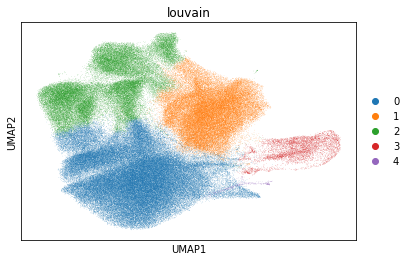

In [13]:
sc.pl.umap(
    singlet_mtx,
    color = ['louvain'])

## DE analysis 
___

In [14]:
#Danny's function
def Get_Gene_Set(data, clustering = 'louvain', cluster = 'All', direction = 'up', pval=0.05):
    if clustering !='louvain' and cluster == 'All':
        print('Must be louvain for All cluster parameter.')
    if cluster == 'All' and clustering == 'louvain':
        for clust in data.obs[clustering].cat.categories:
            pval_genes = data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['pvals_adj'][clust] < pval]
            if direction == 'up':
                filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] > 0]]
            elif direction == 'down':
                filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] < 0]]
            with open('Cluster_' + clust + '_' + direction + "_genes.txt", "a") as f:
                for gene in filtered_genes:
                    f.write(gene + "\n")
    elif cluster != 'Combined' and clustering == 'louvain':
        clust = cluster
        pval_genes = data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['pvals_adj'][clust] < pval]
        if direction == 'up':
            filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] > 0]]
        elif direction == 'down':
            filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] < 0]]
        with open('Cluster_' + clust + '_' + direction + "_genes.txt", "a") as f:
            for gene in filtered_genes:
                f.write(gene + "\n")
    else:
        for sample in data.obs[clustering].cat.categories:
            try:
                pval_genes = data.uns['rank_genes_groups']['names'][sample][data.uns['rank_genes_groups']['pvals_adj'][sample] < pval]
                if direction == 'up':
                    filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][sample][data.uns['rank_genes_groups']['scores'][sample] > 0]]
                elif direction == 'down':
                    filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][sample][data.uns['rank_genes_groups']['scores'][sample] < 0]]
                with open(sample + '_' + direction + "_genes.txt", "a") as f:
                    for gene in filtered_genes:
                        f.write(gene + "\n")
            except:
                continue
    return

In [ ]:
sc.tl.rank_genes_groups(singlet_mtx,
                        groupby='louvain',
                        method='wilcoxon')

In [ ]:
Get_Gene_Set(singlet_mtx)

In [ ]:
singlet_mtx.write('/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/DAA271-DAA286-ER+screens/process_singlets/MB361/sinlget_mtx.h5ad')

### Plot no sgrna cells 
____

In [2]:
FILE_DIR = '/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/DAA271-DAA286-ER+screens/process_singlets/MB361/'
singlet_mtx = sc.read(FILE_DIR + 'sinlget_mtx.h5ad')

In [3]:
singlet_mtx.obs

,n_counts_all,louvain,sgrna_num,No_sgrna,total_reads,ESR1_cpm
TGAGGGACAATCCTAG-7,4501.0,1,33,0,3835,0.000000
AGTCACAGTCGCATCG-8,6692.0,1,46,0,6176,0.000000
GGGTAGATCTGAGCAT-3,6750.0,1,18,0,6495,0.000000
CCGGTAGAGATTGACA-2,3120.0,0,18,0,2602,0.000000
GTGTAACGTGCAACGA-6,6619.0,0,2,0,6039,0.000000
...,...,...,...,...,...,...
GTGCTTCTCCGTGGCA-7,4533.0,0,13,0,4030,0.000000
GTACAACCATATACCG-7,4212.0,0,0,1,3749,0.000000
TTATTGCAGGCAGGGA-4,16313.0,0,5,0,16209,61.694121
CCGTTCAAGCTGGCCT-2,11351.0,0,19,0,10831,0.000000


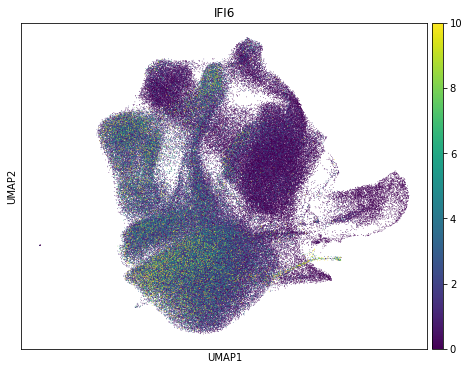

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
sc.pl.umap(
    singlet_mtx, 
    color=['IFI6'],
    size=2,
    vmax=10,
    ax=ax
)

In [ ]:
sgrna_df = pd.read_pickle(FILE_DIR + 'Singlet_sgRNA_df.pkl')
total_sgrna = np.sum(sgrna_df > 0, axis=0)

In [ ]:
sgrna_dict  = {}
sgrnas_file = '/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/MB231-GWAS_SM-combine/All_enhancer_regions_hg38.txt'
with open(sgrnas_file) as f:
    for line in f:
        region_id, sgrna_string = line.strip().split("\t")
        sgrnas = sgrna_string.split(";")
        sgrna_dict.update({region_id : sgrnas})

## Plot sgRNA distribution
___

/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


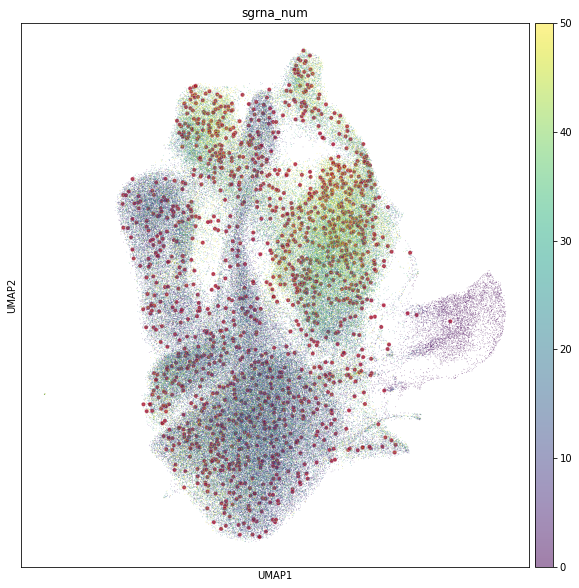

In [53]:
import seaborn as sns

k = 'chr1:40919322-40919917' #CITED4 enhancer
k = 'chr16:56607213-56607713' #MT2A promoter
singlet_mtx.obs[k] = sgrna_df.loc[sgrna_dict[k]].sum() > 0
x = singlet_mtx.obsm['X_umap'][np.where(singlet_mtx.obs[k].values > 0)[0]][:, 0]
y = singlet_mtx.obsm['X_umap'][np.where(singlet_mtx.obs[k].values > 0)[0]][:, 1]


fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x, y, alpha=0.8, size=0.5, color='#A60628', legend=False ,ax=ax)

sc.pl.umap(
    singlet_mtx, 
    color=['sgrna_num'],
    size=2,
    alpha=0.5,
    vmax=50,
    use_raw=True,
    ax=ax)

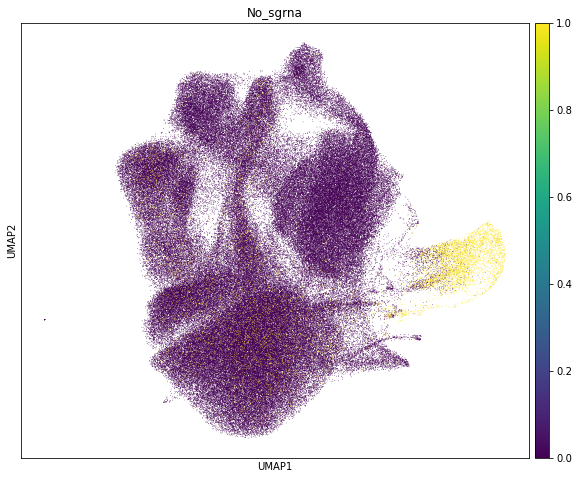

In [5]:
#No_sgrna = singlet_mtx.obs['sgrna_num'] == 0
#singlet_mtx.obs['No_sgrna'] = No_sgrna.astype(int)

fig, ax = plt.subplots(figsize=(10,8))
sc.pl.umap(singlet_mtx, 
           color=['No_sgrna'], 
           size=2,
           ax=ax)

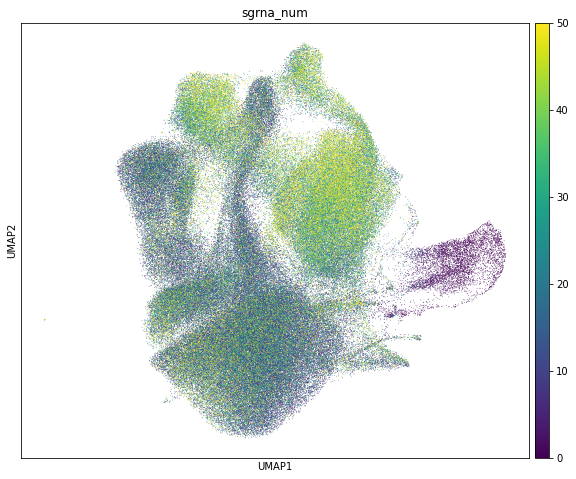

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.umap(singlet_mtx, 
          color=['sgrna_num'],
          size=2, 
          vmax=50,
          ax=ax,
          save='MB361_sgrna_num.png')

## Plot sequencing depth 
_____

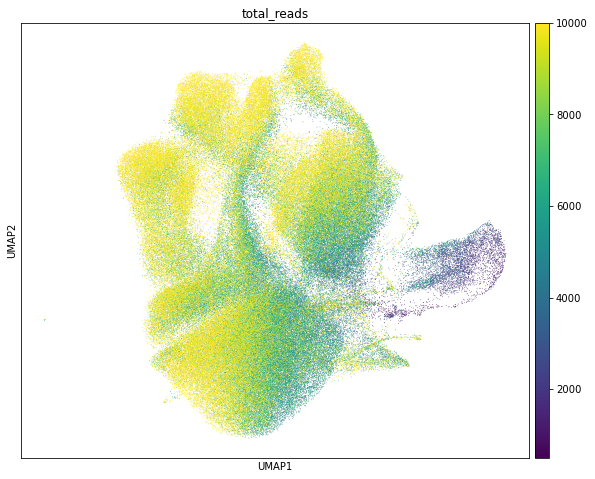

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.umap(
    singlet_mtx, 
    color=['total_reads'],
    size=2,
    vmax=10000,
    ax=ax
)